In [1]:
import pandas as pd
import string
import joblib
import matplotlib.pyplot as plt
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Kita ada 2 dataset.
1. dataset Terraria -> dataset yang kita jadiin target. buat ngecek ini game worthy buat sequel atau ngganya dari sini
2. dataset reviewmodel -> dataset buat ngebuat modelnya.

cara kerja :
1. buat model
2. baca dataset terraria
3. suruh modelnya buat conclusion terhadap data di terraria (bisa plotting, bisa data berbasis text dll)

# MODEL TRAINING

di bagian (df_model = pd.read_csv('dataset/reviewmodel.csv')), 

ini kalo kalian contohnya taro di folder lain bisa ganti jadi df_model = pd.read_csv('nama-folder/reviewmodel.csv') 

atau bisa langsung (df_model = pd.read_csv('reviewmodel.csv')) kalo ga ditaro di folder mana mana

In [2]:
# Load dataset buat model
df_model = pd.read_csv('dataset/reviewmodel.csv', low_memory=False)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   reviewText  object
 1   overall     int64 
dtypes: int64(1), object(1)
memory usage: 39.1+ MB


In [ ]:
# prep (tokenize, stopwords, punctuations)
def remove(text):
    english_stopwords = set(stopwords.words('english'))
    punctuation_list = set(string.punctuation)
    tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
    tokens = [word for word in tokens if word not in english_stopwords and word not in punctuation_list]  # Remove stopwords, punctuation, and non-alphabetic words
    return ' '.join(tokens)

def preprocess_text():
    df_model.dropna(subset=['reviewText'], inplace=True)
    target = df_model['reviewText'].apply(remove)
    return target

In [ ]:
def model_training():
    target = preprocess_text()  # prep reviewText
    label = df_model['overall'].apply(lambda x: 1 if x > 3 else 0)  # rating 1-4 ubah jadi 0 (ga rekomen) rating 5 jadi 1 (rekomen)

    # split data
    X_train, X_test, y_train, y_test = train_test_split(target, label, test_size=0.3, random_state=42)

    # TFIDF + Naive Bayes
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
    model = make_pipeline(vectorizer, MultinomialNB())
    model.fit(X_train, y_train)

    # cek akurasi
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusionMatrix = confusion_matrix(y_test, y_pred)
    classificationReport = classification_report(y_test, y_pred)
    with open("Main NB Metrics.txt", "w", encoding="utf-8") as f:
        f.write(f'Accuracy:\n{accuracy * 100:.2f}%\n\n')
        f.write(f'Confusion Matrix:\n{confusionMatrix}\n\n')
        f.write(f'Classification Report:\n{classificationReport}\n')

    # display 5 contoh
    for review, true_label, pred_label in zip(X_test[:5], y_test[:5], y_pred[:5]):  
        print(f"Review: {review}\nTrue Sentiment: {true_label}\tPredicted Sentiment: {pred_label}")
        print("-" * 50)

    # save model
    with open("Main NB Model.pkl", "wb") as f:
        joblib.dump(model, f)

    return model

biar gaperlu nge load modelnya lama lama lagi kalo udah punya

In [ ]:
try:
    # coba load model kalo udah ada biar gaperlu run data training lama lama
    print("loading model...")
    with open("Main NB Model.pkl", "rb") as f:
        classifier = joblib.load(f)
    print("model loaded")
except:
    # kalo belom ada modelnya, training model dulu
    print("training model...")
    classifier = model_training()
    print("model trained")

loading model...
training model...
Review: bought son loved
True Sentiment: 1	Predicted Sentiment: 1
--------------------------------------------------
Review: year old loves
True Sentiment: 1	Predicted Sentiment: 1
--------------------------------------------------
Review: well bought dropped lot held broke still love
True Sentiment: 0	Predicted Sentiment: 1
--------------------------------------------------
Review: one game every car car game fan car selection excellent even enhanced mclaren game sequel three games need speed need speed ii need speed iii hot pursuit great games may cost less money buy fan exotic cars pushing extreme levels beautiful places favorite dolphin cove put money make sure buy right
True Sentiment: 1	Predicted Sentiment: 1
--------------------------------------------------
Review: like mouse gives control dpi weight ergonomically even noticed mouse good thing
True Sentiment: 1	Predicted Sentiment: 1
--------------------------------------------------
model tra

# LOAD DATASET GAMENYA (TARGET)

di bagian (df_games = pd.read_csv('dataset/Terraria.csv')), 

ini kalo kalian contohnya taro di folder lain bisa ganti jadi df_games = pd.read_csv('nama-folder/Terraria.csv') 

atau bisa langsung (df_games = pd.read_csv('Terraria.csv')) kalo ga ditaro di folder mana mana

In [6]:
# Load dataset gamenya buat jadi target
df_games = pd.read_csv('dataset/Terraria.csv')
print(df_games['app_name'].value_counts().to_string())

app_name
Terraria    84828


In [7]:
# drop data yang null
df_games.isnull().sum()
df_games.dropna(subset=['review_text'], inplace=True)

In [8]:
# ganti nama jadi target aja sebenernya gabegitu penting
target = df_games['review_text']

# MERGING

In [9]:
# fit dataset game ke model
target_vectorized = classifier.named_steps['tfidfvectorizer'].transform(target)
targetSentiment = classifier.named_steps['multinomialnb'].predict(target_vectorized)

In [10]:
# print data sentiment 1 sama 0
print((targetSentiment == 1).sum())
print((targetSentiment == 0).sum())

62897
21805


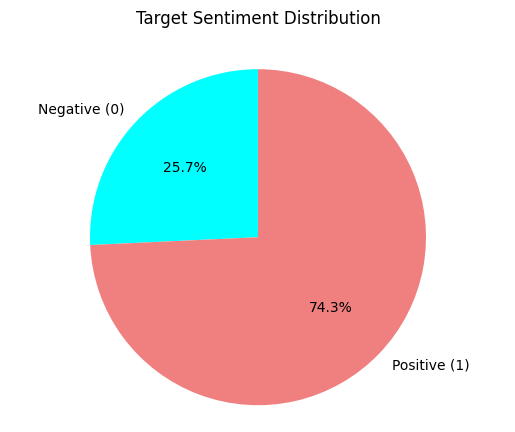

In [11]:
# plotting
counts = [(targetSentiment == 0).sum(), (targetSentiment == 1).sum()]
labels = ["Negative (0)", "Positive (1)"]
colors = ["cyan", "lightcoral"]

plt.pie(counts, labels=labels, autopct='%.1f%%', colors=colors, startangle=90)
plt.title("Target Sentiment Distribution\n")
plt.axis('equal') 
plt.show()

### kesimpulan

sentiment 1 = positif || sentiment 2 = negatif

dataset 'dataset' = dataset utama buat predict sentiment game via reviewnya

di dataset videogames.csv (dataset buat training model NLP Naive Bayes), itu targetnya rating (1-5). gue set rating 1-3 itu 0 (negatif) 4-5 itu 1 (positif)